# **UCB W207 Final Project**

## Using Machine Learning to Predict Travel Review Sentiment

Section 3
18 April 2025

Kevin Yi, Kritin Nandish, Thrishna Bhandari, Patrick Abousleiman


# Introduction: Problem Motivation
Despite the rise in vacation rental properties like Airbnb, hotels remain the most popular form of accommodation for most travellers worldwide. With the rise of global air travel, making informed decisions about where to stay when in a new city for work or vacation has never been more important. 

Tripadvisor is one of the most reliable platforms to search for and book hotels with over one billion recorded reviews by users who have taken advantage of the services' wide range of offerings. Users have the ability to write reviews of their experience at a location on Tripadvisor and then award the location a rating on a scale from 1 to 5 stars. But because users can write reviews and also give each hotel a star rating, this can create a lack of standardization of the scale used where reviews that may be very semantically similar might have star ratings that differ from each other due to the subjectivity of the reviewer. 

In this project we seek to create a model that can predict whether a hotel rating is positive or negative based on the review produced by a Tripadvisor user. We will explore how different features of a review can impact the overall rating of a hotel and attempt to produce a model that can help users gain a more accurate idea of what they can expect from a hotel with certain types of reviews.


## Outline for our notebook

* Section 1: We import the data, the source being the Tripadvisor Hotel Review Dataset file with 20K reviews, from the publication: Alam, M. H., Ryu, W.-J., Lee, S., 2016. Joint multi-grain topic senti- ment: modeling semantic aspects for online reviews. Information Sci- ences 339, 206–223.
* Section 2: We undertake feature engineering and data cleaning.
* Section 3: Simple exploratory data analysis is performed.
* Section 4:  We build 7 models, starting from the baseline model, logistic regression with one hot encoding, logistic regression with embedding, multilayer CNN, multilayer CNN with hyperparameter tuning, transfer learning using transformer model, and fine tuning transformer model. 
* Section 5:  Conclusions from our analysis. 

In [1]:
# Import the libraries we'll use below.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import pandas as pd
import seaborn as sns 
sns.set(style="darkgrid") 
import plotly.graph_objs as plotly  
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras import models


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import keras_tuner as kt
from keras_tuner import HyperModel, Hyperband
import regex as re
import tqdm


from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split

# BERT
import transformers
from transformers import  AutoTokenizer, TFAutoModelForSequenceClassification, TFAutoModel, BertTokenizer, TFBertForSequenceClassification
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.metrics import AUC, Precision
from sklearn.metrics import precision_score, recall_score, roc_auc_score

#setting  seed
np.random.seed(100)





A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/opt/anaconda3/envs/tf_env/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/anaconda3/envs/tf_env/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/opt/anaconda3/envs/tf_env/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/envs/tf_env/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start

# Section 1: Importing data

Our primary data source is the Tripadvisor Hotel Reviews dataset from Kaggle. The dataset is not preprocessed and will need to be cleaned before the analysis and modelling can take place.

The data only includes two features: Review and Rating. Review is the first column and contains each user generated review as a string. Rating contains integer values from 1 to 5 that represent the star rating of each hotel that was given a review. In total the data frame contains 20,491 rows and 2 features.

In [2]:
data = pd.read_csv('tripadvisor_hotel_reviews.csv')

#Data Investigation
#We are considering reviews of ratings 3 as negative reviews.
positive_reviews = data[data['Rating'] >= 4]
negative_reviews = data[data['Rating'] <= 3]
print(f"In this dataset of {data.shape[0]} total hotel ratings, there are {positive_reviews.shape[0]} positive ratings, and {negative_reviews.shape[0]} negative hotel ratings.")


In this dataset of 20491 total hotel ratings, there are 15093 positive ratings, and 5398 negative hotel ratings.


# Section 2: Feature engineering

Our primary data source is the Tripadvisor Hotel Reviews dataset from Kaggle. The dataset is not preprocessed and will need to be cleaned before the analysis and modelling can take place.

The data only includes two features: Review and Rating. Review is the first column and contains each user generated review as a string. Rating contains integer values from 1 to 5 that represent the star rating of each hotel that was given a review. In total the data frame contains 20,491 rows and 2 features.

In [3]:
#Data Preprocessing
#checking null values
missing_values = data['Rating'].isnull().any() or data['Review'].isnull().any() # equals False
#There are no missing values in either data column.

In [4]:
#Preprocessing Functions
def preprocessor(text): 
    #Data cleaning
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = (re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', ''))
    return text

def replace_contractions(df, column_name):
    #Replace contractions
    df[column_name] = df[column_name].str.replace(r"ca n't\b", "can not", regex=True)
    df[column_name] = df[column_name].str.replace(r"n't\b", "not", regex=True)
    df[column_name] = df[column_name].str.replace(r"n t\b", "not", regex=True)
    return df

After applying both of these normalization functions to the data and resetting the index, we split the dataset into two groups representing positive reviews and negative reviews. The positive_reviews dataset contained all the rows where the rating was at least a 4 and the negative_reviews dataset contained all the rows where the rating was at most a 3. Finally, we changed the values in the the Rating column of the original data frame into binary variables with 0 representing negative ratings of 3 and below and 1 representing positive ratings of 4 and above. 

In [5]:
#Apply preprocessing
data['Review'] = data['Review'].str.lower()
data['Review'] = data['Review'].apply(preprocessor)

data = replace_contractions(data, 'Review')
data
#We found one row with several typos that we cannot discern the original meaning and will be removing it from the data
data = data.drop(index=2759)

data = data.reset_index(drop=True)

#Redefine negative and positive data subsets with clean data
positive_reviews = data[data['Rating'] >= 4]
negative_reviews = data[data['Rating'] <= 3]

# Section 3: Exploratory Data Analysis

### Histogram Analysis

We start our analysis by plotting the distribution of positive and negative ratings in the dataset using a histogram. It is immediately apparent that there are far more positive ratings than negative ratings in the data at a 3 to 1 ratio. When evaluating our models, we will be using recall, precision, and Area Under the Curve (AUC) for a Precision-Recall (PR) curve instead of accuracy. 

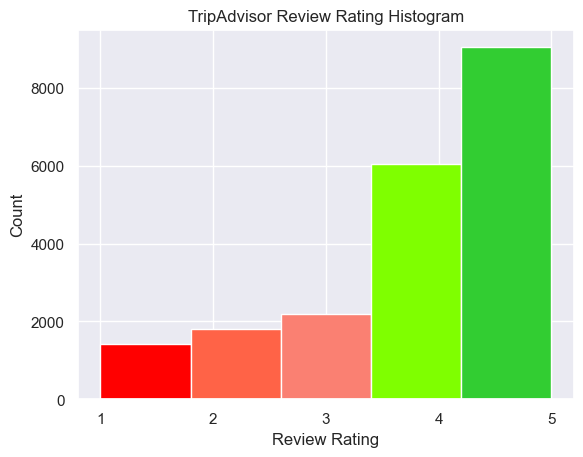

In [6]:
sns.histplot(data['Rating'], bins=5, kde=False) #create histogram of ratings in full dataset

# get the bins to modify color
ax = plt.gca()
patches = ax.patches

# assign colors to bins, shades of red for negative ratings, grey for neutral, shades of green for positive ratings
colors = ['red', 'tomato', 'salmon', 'chartreuse', 'limegreen']
for patch, color in zip(patches, colors):
    patch.set_facecolor(color)

# set title, labels, and x-axis labels
plt.xticks([1, 2, 3, 4, 5]) 
plt.title("TripAdvisor Review Rating Histogram")
plt.xlabel("Review Rating")
plt.show()

### Word Cloud Analysis

Next we were interested in exploring the reviews themselves and looking for common words that exist in positive and negative reviews. To do this we generated two word clouds that illustrate the frequency of words in positive and negative reviews by the size of the words. Our results show that some of the most common words in both positive and negative reviews are room, hotel, time, and day. Although it makes sense that these words appear the most frequently due to the context of the reviews, they are not very helpful alone in determining the rating of a hotel since none of these most common words are inherently positively or negatively charged.

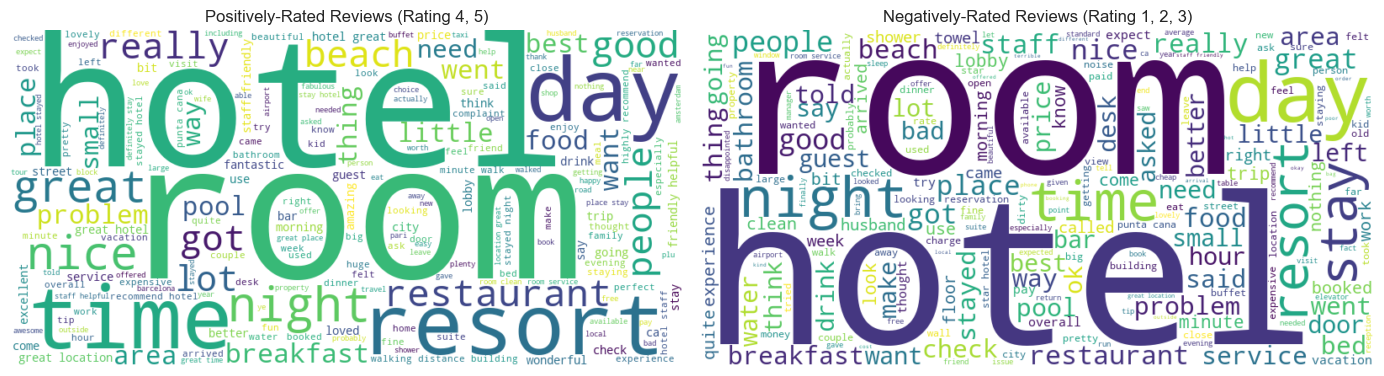

In [7]:
# create a word cloud for negative reviews
negative_review_text = " ".join(negative_reviews['Review'])
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_review_text)

# create a word cloud for positive reviews
positive_review_text = " ".join(positive_reviews['Review'])
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_review_text)

# set up the figure with two side-by-side subplots for the positive review and negative review word clouds
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].imshow(positive_wordcloud, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title("Positively-Rated Reviews (Rating 4, 5)") # set title
axes[1].imshow(negative_wordcloud, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title("Negatively-Rated Reviews (Rating 1, 2, 3)") # set title

# show the plots
plt.tight_layout()
plt.show()

### Review Length Analysis

Another interesting feature to consider is the distribution of the review lengths for both positive and negative reviews. In order to visualize this we chose to plot two histograms depicting the count of the lengths for each review type along with summary statistics for each histogram. At first glance both histograms look similarly distributed with lengths clustered towards the shorter side and noticeable right tails. However upon further inspection of the summary statistics we can see that the average length of negative reviews of 792.8 characters is significantly higher than the average length of positive reviews which is 682.0 characters. This could help serve as a potential indication about whether a review is positive or negative. 

Counts for positive reviews: 
 Minimum: 41 
 Max: 12356 
 Mean: 682.0227257669118

Counts for negative reviews: 
 Minimum: 45 
 Max: 13239 
 Mean: 792.8273114693349


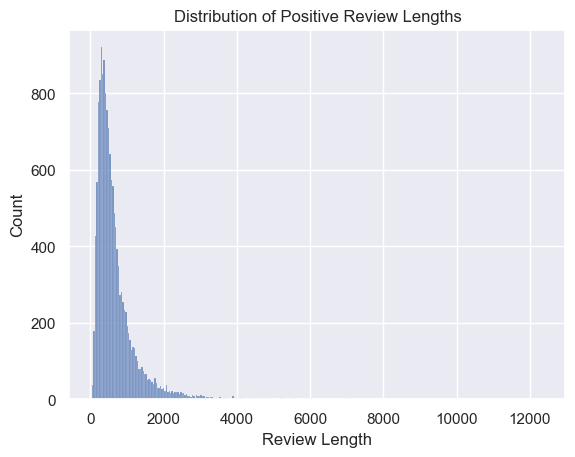

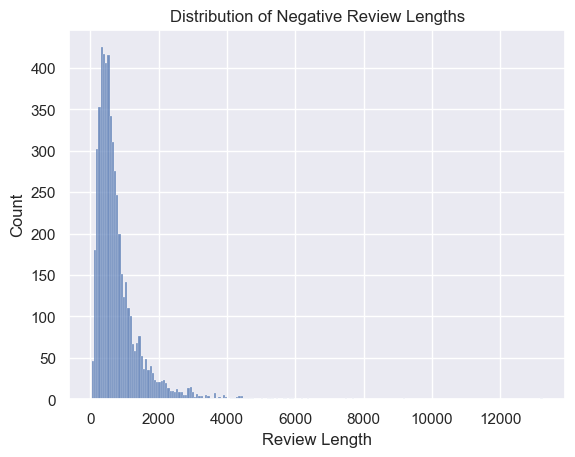

In [8]:
# get min, max, mean lengths for positive reviews. 
pos_reviews_length = [len(review) for review in positive_reviews['Review']]
min_pos = min(pos_reviews_length)
max_pos = max(pos_reviews_length)
mean_pos = sum(pos_reviews_length) / len(pos_reviews_length)

# get min, max, mean lengths for negative reviews. 
neg_reviews_length = [len(review) for review in negative_reviews['Review']]

min_neg = min(neg_reviews_length)
max_neg = max(neg_reviews_length)
mean_neg = sum(neg_reviews_length) / len(neg_reviews_length)

print(f'Counts for positive reviews: \n Minimum: {min_pos} \n Max: {max_pos} \n Mean: {mean_pos}')
print(f'\nCounts for negative reviews: \n Minimum: {min_neg} \n Max: {max_neg} \n Mean: {mean_neg}')

# Create histogram of positive review length counts. 
sns.histplot(pos_reviews_length)
plt.title('Distribution of Positive Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Count')
plt.show()


# Create histogram of negative review length counts. 
sns.histplot(neg_reviews_length)
plt.title('Distribution of Negative Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Count')
plt.show()

## View unique word count in the Reviews 

In [9]:
all_text = ' '.join(data['Review'].astype(str))  # Join all reviews into one big string
all_words = all_text.split()                     # Split by whitespace
unique_words = set(all_words)                    # Use a set to get unique words

print("Unique word count:", len(unique_words))

Unique word count: 52983


### Binary Classification: Positive or Negative

In [10]:
#Redefine data with binary classification for reviews. We combine 0-3 ratings as 0 and 4-5 as 1
data['Rating'] = data['Rating'].apply(lambda x: 0 if x <= 3 else 1)


### Splitting Data

The last step before beginning the modeling process is to split our dataset into training, testing, and validation groups. We begin by randomly shuffling the indices of our original dataset in order to make the data split as equally distributed as possible. We then call the train_test_split function on the shuffled dataset to split the data into 80% training data and 20% testing data. From there we call the function again on the newly created training data to create a validation dataset that is 25% of the training dataset.

In [ ]:
# shuffle data -- data will be the biased data with either a positive or negative review

# Apply random shufflying to training examples.
np.random.seed(0)
indices = np.arange(0, data.shape[0]) #create indices list
shuffled_indices = np.random.permutation(indices) #shuffle indices
reviews = data['Review'] #create examples
ratings = data['Rating'] #create labels
reviews = reviews[shuffled_indices] #reorder dataset to match shuffled indices
ratings = ratings[shuffled_indices] #reorder dataset to match shuffled indices
    
# Initial split into training (80%) and testing (20%)
X_train, X_test, Y_train, Y_test = train_test_split(reviews, ratings, random_state=1234, test_size=0.20)

# Split 25% of the training into a validation set
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, random_state=1234, test_size=0.25)

### Analyze Split Data 

In [12]:
# print shapes
print('Shape of train examples ', X_train.shape)
print('Shape of train labels ', Y_train.shape)

print('Shape of val examples ', X_val.shape)
print('Shape of val labels ', Y_val.shape)

print('Shape of test examples ', X_test.shape)
print('Shape of test labels ', Y_test.shape)

Shape of train examples  (12294,)
Shape of train labels  (12294,)
Shape of val examples  (4098,)
Shape of val labels  (4098,)
Shape of test examples  (4098,)
Shape of test labels  (4098,)


### Tokenize Data

Finally, we convert the reviews in all three groups into numeric tokens by changing the 5000 most common words in the data into integer values and any other words to the value “<OOV>”. We also padded the data to a length of 1000 characters to ensure that all the reviews were the same length when being inputted into the model. These tokens will be used for our neural network based model.

In [13]:
# Initialize Tokenizer
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")

# Fit the tokenizer on the X_train data (only fit on training data)
tokenizer.fit_on_texts(X_train)

# Convert the reviews to sequences of integers (tokens)
X_train_tokens = tokenizer.texts_to_sequences(X_train)
X_test_tokens = tokenizer.texts_to_sequences(X_test)
X_val_tokens = tokenizer.texts_to_sequences(X_val)

# Pad the data to ensure they are all the same length (maxlen=1000)
X_train_padded = pad_sequences(X_train_tokens, maxlen=1000, dtype='int32', padding='post', truncating='post', value=0)
X_test_padded = pad_sequences(X_test_tokens, maxlen=1000, dtype='int32', padding='post', truncating='post', value=0)
X_val_padded = pad_sequences(X_val_tokens, maxlen=1000, dtype='int32', padding='post', truncating='post', value=0)



# Section 4: Model Building and Predictions.

Now we’ll begin the modeling process in an attempt to create a machine learning model that can most accurately predict whether or not a review corresponds to a hotel with a positive or negative rating. Our first model will be a baseline that will yield a benchmark accuracy that we will aim to improve on.

## Model 1: Baseline Model (Majority Class - Positive Reviews) 

We train a baseline model that will always predict the review to be positive based on our training data (the majority class). These are metrics we will aim to surpass by our last model. This model provides initial measures of accuracy and loss that we will try to improve in the following models.

Our results for the baseline show that there is a test accuracy of 0.7385 and an AUC of 0.5000. These initial statistics are decent but can certainly be improved upon in more complex models.


In [14]:
y_test_baseline = [1] * len(Y_test)
y_val_baseline = [1] * len(Y_val)

y_test = np.array(Y_test)
y_val = np.array(Y_val)
y_test_baseline = np.array(y_test_baseline)
y_val_baseline = np.array(y_val_baseline)


test_precision = precision_score(Y_test, y_test_baseline, average='binary', zero_division=0)
test_recall = recall_score(Y_test, y_test_baseline, average='binary', zero_division=0)

val_precision = precision_score(Y_val, y_val_baseline, average='binary', zero_division=0)
val_recall = recall_score(Y_val, y_val_baseline, average='binary', zero_division=0)

y_test_probs = [1.0 if pred == 1 else 0.0 for pred in y_test_baseline]
y_val_probs = [1.0 if pred == 1 else 0.0 for pred in y_val_baseline]

test_auc = roc_auc_score(Y_test, y_test_probs)
val_auc = roc_auc_score(Y_val, y_val_probs)

print(f"Test Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, AUC: {test_auc:.4f}")
print(f"Val  Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, AUC: {val_auc:.4f}")

Test Precision: 0.7272, Recall: 1.0000, AUC: 0.5000
Val  Precision: 0.7404, Recall: 1.0000, AUC: 0.5000


## Model 2: One Hot Encoding Regression

In the next model we seek to improve our results from the baseline outcome by employing hot one encoding into our model. We start by tokenizing the 1000 most common words in the dataset and padding each review to a maximum of 100 characters. We limit to max length 100 and 1000 most common words because one hot coding is very memory intensive and our computer was running out of memory for longer lengths. This is followed by the one hot encoding function that turns every individual word into a vector of 0s and 1s with length of 1000 each. Then we build a model that includes the ‘sigmoid’ activation function for binary classification in order to predict whether each review is positive or negative. Then we finally train the model on the training dataset before returning summary statistics.

This model seems to have almost exactly the same prediction power as our baseline model with 0.7389 accuracy on the test dataset. However, we also see an increase in the AUC to 0.613, which indicates that the model is more powerful than the baseline in predicting whether the review is positive or negative. 

In [15]:

vocab_size = 1000  # smaller vocab to avoid memory issues
maxlen = 100

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)


X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)


X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=maxlen, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post', truncating='post')


X_train_oh = tf.one_hot(X_train_pad, depth=vocab_size)
X_val_oh = tf.one_hot(X_val_pad, depth=vocab_size)
X_test_oh = tf.one_hot(X_test_pad, depth=vocab_size)


def build_onehot_model(average_over_positions=False):
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    model = tf.keras.Sequential()

    if average_over_positions:
        model.add(tf.keras.layers.GlobalAveragePooling1D(input_shape=(maxlen, vocab_size)))
    else:
        model.add(tf.keras.layers.Flatten(input_shape=(maxlen, vocab_size)))

    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy', AUC(name='auc')]
    )
    
    return model


model = build_onehot_model(average_over_positions=True)

history = model.fit(
    X_train_oh, Y_train,
    validation_data=(X_val_oh, Y_val),
    epochs=10,
    batch_size=32,
    verbose=1
)
y_train_probs = model.predict(X_train_oh)
y_val_probs = model.predict(X_val_oh)

y_train_pred = (y_train_probs >= 0.5).astype(int).flatten()
y_val_pred = (y_val_probs >= 0.5).astype(int).flatten()

print("\n--- Training Set Evaluation ---")
print("Accuracy:", accuracy_score(Y_train, y_train_pred))
print("Precision:", precision_score(Y_train, y_train_pred))
print("Recall:", recall_score(Y_train, y_train_pred))
print("AUC:", roc_auc_score(Y_train, y_train_probs))

print("\n--- Validation Set Evaluation ---")
print("Accuracy:", accuracy_score(Y_val, y_val_pred))
print("Precision:", precision_score(Y_val, y_val_pred))
print("Recall:", recall_score(Y_val, y_val_pred))
print("AUC:", roc_auc_score(Y_val, y_val_probs))


Epoch 1/10


/opt/anaconda3/envs/tf_env/lib/python3.9/site-packages/keras/src/layers/pooling/base_global_pooling.py:12: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


385/385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7310 - auc: 0.5182 - loss: 0.6612 - val_accuracy: 0.7404 - val_auc: 0.6821 - val_loss: 0.5966
Epoch 2/10
385/385 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7376 - auc: 0.6463 - loss: 0.5881 - val_accuracy: 0.7404 - val_auc: 0.7030 - val_loss: 0.5681
Epoch 3/10
385/385 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7376 - auc: 0.7076 - loss: 0.5665 - val_accuracy: 0.7404 - val_auc: 0.7143 - val_loss: 0.5579
Epoch 4/10
385/385 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7376 - auc: 0.7237 - loss: 0.5579 - val_accuracy: 0.7404 - val_auc: 0.7221 - val_loss: 0.5518
Epoch 5/10
385/385 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7376 - auc: 0.7327 - loss: 0.5519 - val_accuracy: 0.7404 - val_auc: 0.7299 - val_loss: 0.5465
Epoch 6/10
385/385 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7376 - auc: 0.7409 - loss: 0.5466 - val_accuracy: 0.7404 - val_auc: 0.7372 - val_loss: 0.5416
Epoch 7/10
385/385 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

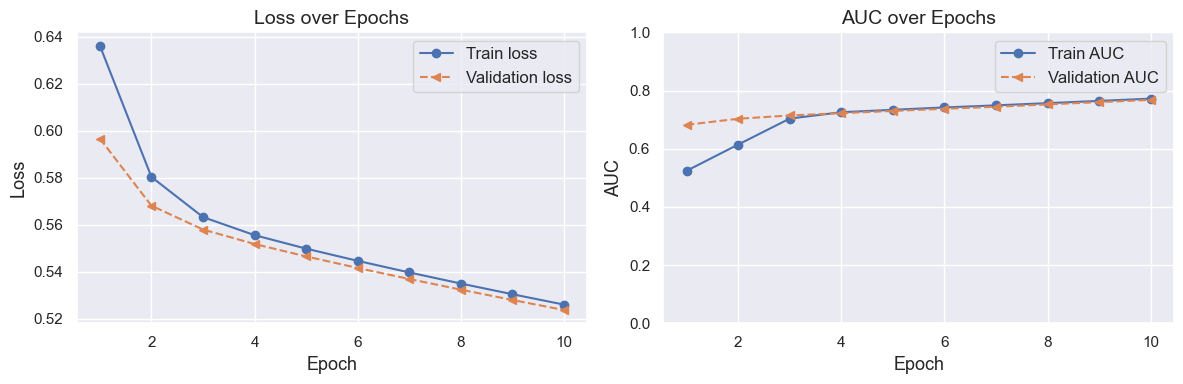

In [16]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

# Plot loss and AUC
fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=13)
ax.set_ylabel('Loss', size=13)
ax.set_title('Loss over Epochs', size=14)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['auc'], '-o', label='Train AUC')
ax.plot(x_arr, hist['val_auc'], '--<', label='Validation AUC')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=13)
ax.set_ylabel('AUC', size=13)
ax.set_ylim(0, 1)
ax.set_title('AUC over Epochs', size=14)

plt.tight_layout()
plt.show()

In [17]:
y_probs = model.predict(X_test_oh)
y_pred = (y_probs >= 0.5).astype(int).flatten()

# Metrics
print("Accuracy:", accuracy_score(Y_test, y_pred))
print("Precision:", precision_score(Y_test, y_pred))
print("Recall:", recall_score(Y_test, y_pred))
print("AUC:", roc_auc_score(Y_test, y_probs))

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 0.7271839921913128
Precision: 0.7271839921913128
Recall: 1.0
AUC: 0.7830987141467867


## Model 3: Logistic regression with embeddings

The following model uses text embeddings in order to create a neural network that determines whether a review is positive or negative. It creates an embedding layer for the words in each entry before determining the average value of the embedding layer for each review. We then call the ‘sigmoid’ activation function to classify each review as positive or negative. Finally, we compile and train the model on the training set over 10 epochs.

By the final epoch we still see that the model’s prediction accuracy on the test data has increased from the baseline model to an accuracy of 0.88. The test AUC improved dramatically from the last model to 0.943 and the test loss was 0.28.

In [18]:
def build_embeddings_model(average_over_positions=True,
                           vocab_size=5000,
                           sequence_length=1000,
                           embedding_dim=64):
  """Build a tf.keras model using embeddings."""
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Embedding(
      input_dim=vocab_size,
      output_dim=embedding_dim,
      input_length=sequence_length)
  )

  if average_over_positions:
    # This layer averages over the first dimension of the input by default.
    model.add(tf.keras.layers.GlobalAveragePooling1D())
  else:
    # Concatenate.
    model.add(tf.keras.layers.Flatten())
      
  model.add(tf.keras.layers.Dense(
      units=1,                     # output dim (for binary classification)
      activation='sigmoid'         # apply the sigmoid function!
  ))
  model.compile(
    loss='binary_crossentropy', 
    optimizer='adam',
    metrics=['accuracy', AUC(name='auc'), Precision(name='precision')]
  )



  return model

In [19]:

model2 = build_embeddings_model(average_over_positions=True,
                               vocab_size=5000,
                               sequence_length=1000,
                               embedding_dim=64)
history2 = model2.fit(
  x = X_train_padded,  # our sparse padded training data
  y = Y_train,          # corresponding binary labels
  epochs=10,             # number of passes through the training data
  batch_size=32,        # mini-batch size
  validation_data= (X_val_padded, Y_val), 
  verbose=1             # display some progress output during training
  )

model2.summary()

history2 = pd.DataFrame(history2.history)

Epoch 1/10


/opt/anaconda3/envs/tf_env/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


385/385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7373 - auc: 0.5433 - loss: 0.5768 - precision: 0.7378 - val_accuracy: 0.7382 - val_auc: 0.6772 - val_loss: 0.5619 - val_precision: 0.7400
Epoch 2/10
385/385 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7374 - auc: 0.5984 - loss: 0.5650 - precision: 0.7387 - val_accuracy: 0.7394 - val_auc: 0.7436 - val_loss: 0.5533 - val_precision: 0.7409
Epoch 3/10
385/385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7399 - auc: 0.6527 - loss: 0.5520 - precision: 0.7410 - val_accuracy: 0.7416 - val_auc: 0.8085 - val_loss: 0.5427 - val_precision: 0.7423
Epoch 4/10
385/385 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7449 - auc: 0.7148 - loss: 0.5301 - precision: 0.7457 - val_accuracy: 0.7491 - val_auc: 0.8770 - val_loss: 0.5014 - val_precision: 0.7483
Epoch 5/10
385/385 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7663 - auc: 0.7968 - loss: 0.4891 - precision: 0.7641 - val_accuracy: 0.7582 - val_auc: 0.9032 - val_loss: 0.4727 - val_precision

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 1000, 64)       │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 960,197 (3.66 MB)

 Trainable params: 320,065 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 640,132 (2.44 MB)

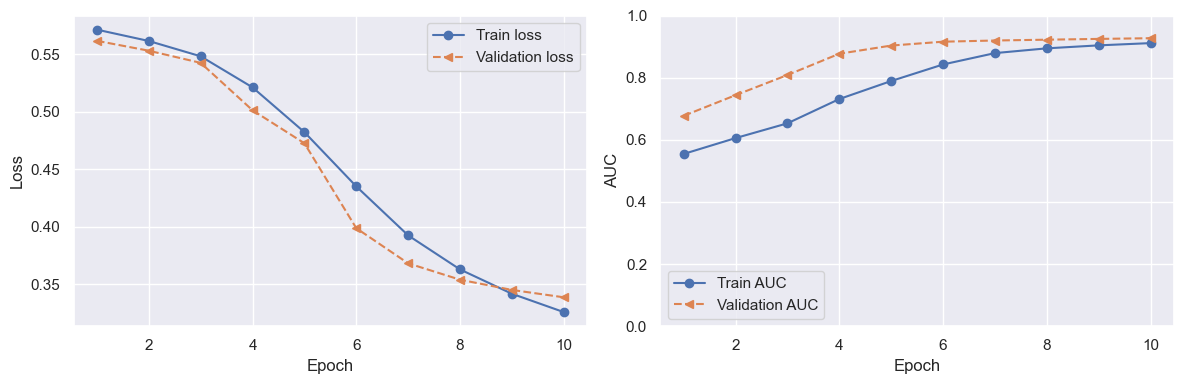

In [20]:
x_arr = np.arange(len(history2['loss'])) + 1

fig = plt.figure(figsize=(12, 4))

# Plot Loss
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(x_arr, history2['loss'], '-o', label='Train loss')
ax1.plot(x_arr, history2['val_loss'], '--<', label='Validation loss')
ax1.legend()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

# Plot AUC
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(x_arr, history2['auc'], '-o', label='Train AUC')
ax2.plot(x_arr, history2['val_auc'], '--<', label='Validation AUC')
ax2.legend()
ax2.set_xlabel('Epoch')
ax2.set_ylabel('AUC')
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()

In [21]:
test_loss, test_accuracy, test_auc, test_precision = model2.evaluate(X_test_padded, Y_test)

print(f'Test Loss: {test_loss}')
print(f'Test recall: {test_recall}')
print(f'Test AUC: {test_auc}')
print(f'Test Precision: {test_precision}')

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8784 - auc: 0.9298 - loss: 0.3360 - precision: 0.9249
Test Loss: 0.34144753217697144
Test recall: 1.0
Test AUC: 0.9263582229614258
Test Precision: 0.9216826558113098


## Model 4: CNN Convolutional neural network with embdeddment and no hyperparameter tuning

In this model we’ve created a convolutional neural network with an embedding layer used to transform the words in the reviews into numeric values. We also chose to add convolution, pooling, dropout, flattening, and classification layers to the model before returning the final compiled output. 

After training the model using the training dataset using a learning rate of .01 and 10 epochs, we are able to yield a final validation accuracy of 0.95 and a validation loss of 0.1870. This is a fairly strong result compared to our previous models. We’ve also generated an AUC curve that demonstrates high performance from this model with both the training and validation AUC values being very close to .99 by the final epoch.

The final step for this model was to evaluate its accuracy on the unseen test data. By running the evaluate function, we are able to see that the model is still very precise for new unseen data which means it generalizes well. The test AUC of 0.99 and test loss of 0.089 are good indications that the model is not overfitting on the training data and can perform well if new reviews are introduced.


In [26]:
# initialize model
model_tf = tf.keras.Sequential()

# Add embedding layer to map tokens to embeddings
model_tf.add(tf.keras.layers.Embedding(input_dim=5000,  # Vocabulary size 
                                      output_dim=64,  # Embedding size 
                                      input_length=1000))  # Sequence length 

# add convolutional layer
model_tf.add(tf.keras.layers.Conv1D(
        filters=12,
        kernel_size=4,
        strides = 1, 
        padding='same',
        data_format = 'channels_last',
        name = 'conv_1',
        activation='relu'))

# add max pooling layer 
model_tf.add(tf.keras.layers.MaxPooling1D(pool_size=2))

# add dropout layer
model_tf.add(tf.keras.layers.Dropout(rate=0.3))

# add a flattening layer
model_tf.add(tf.keras.layers.Flatten())

# add the classification layer
model_tf.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# build and compile model
model_tf.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy',
                    tf.keras.metrics.AUC(name='auc'),
                    tf.keras.metrics.Precision(name='precision'),
                    tf.keras.metrics.Recall(name='recall')])


# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',           # Monitor validation loss
    patience=3,                   # Stop after 3 epochs of no improvement
    restore_best_weights=True     # Restore best model weights after stopping
)

# train model_tf on (X_train, y_train) data
history = model_tf.fit(
    X_train_padded,
    Y_train,
    validation_data= (X_val_padded, Y_val),
    epochs=10,
    callbacks=[early_stopping]   # Add early stopping 
)

# print model_tf summary
model_tf.summary()



Epoch 1/10
385/385 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.7837 - auc: 0.8066 - loss: 0.6018 - precision: 0.8085 - recall: 0.9302 - val_accuracy: 0.8904 - val_auc: 0.9320 - val_loss: 0.3033 - val_precision: 0.9061 - val_recall: 0.9506
Epoch 2/10
385/385 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9003 - auc: 0.9435 - loss: 0.2714 - precision: 0.9252 - recall: 0.9410 - val_accuracy: 0.8804 - val_auc: 0.9334 - val_loss: 0.3271 - val_precision: 0.9232 - val_recall: 0.9146
Epoch 3/10
385/385 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9337 - auc: 0.9744 - loss: 0.1799 - precision: 0.9503 - recall: 0.9604 - val_accuracy: 0.8809 - val_auc: 0.9105 - val_loss: 0.4666 - val_precision: 0.8931 - val_recall: 0.9532
Epoch 4/10
385/385 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9423 - auc: 0.9774 - loss: 0.1759 - precision: 0.9566 - recall: 0.9655 - val_accuracy: 0.8738 - val_auc: 0.9055 - val_loss: 0.5110 - val_precision: 0.8956 - val_recall: 0.9390


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 1000, 64)       │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv1D)                 │ (None, 1000, 12)       │         3,084 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 500, 12)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 500, 12)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         6,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 987,257 (3.77 MB)

 Trainable params: 329,085 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 658,172 (2.51 MB)

Print out the loss and AUC curve of our final model on test data


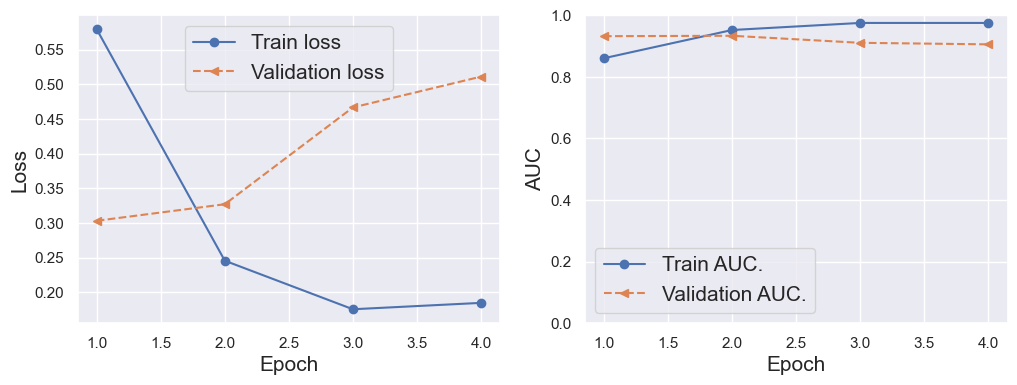

In [27]:
# plot loss curves
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)



# evaluate the AUC of model on (X_train_padded, y_train) and (X_val_padded, y_val)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['auc'], '-o', label='Train AUC.')
ax.plot(x_arr, hist['val_auc'], '--<', label='Validation AUC.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('AUC', size=15)
ax.set_ylim(0,1)
plt.show()

Evaluate our model

In [28]:
# Evaluate the model on test data
test_loss, test_accuracy, test_auc, test_precision, test_recall = model_tf.evaluate(X_test_padded, Y_test)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')
print(f'Test AUC: {test_auc}')
print(f'Test Precision: {test_precision}')
print(f'Test Recall: {test_recall}')

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8934 - auc: 0.9218 - loss: 0.3223 - precision: 0.9066 - recall: 0.9534
Test Loss: 0.32779377698898315
Test Accuracy: 0.889214277267456
Test AUC: 0.9232596158981323
Test Precision: 0.8991782665252686
Test Recall: 0.9546979665756226


## Model 5: CNN Convolutional neural network with hyperparameter tuning

Despite the high accuracy of our first CNN model our team was eager to determine if it could be improved upon by altering the hyperparameters in order to maximize the model's performance. In this iteration, we’ve incorporated a hyperparameter tuning function to change the hyperparameters of the model in order to find the ideal values for the different hyperparameters that the model will be built with. The result is an effective model that has more optimal initial parameters and better generalizability potential.

The final results of this model were very successful with a test accuracy of 0.998 and a loss of just 0.0069. The AUC for this is still very close to 1 on the test data for this model as well.

In [29]:

#Fine-tune the number of hidden layers and the hyperparameters of model_cnn to determine the setup that yields the most optimal generalization performance.
class DRHyperModel(HyperModel):
    def build(self, hp):
        model_cnn = tf.keras.Sequential()

        # Embedding layer (input layer) for text data
        model_cnn.add(Embedding(
            input_dim=5000,  # Vocabulary size 
            output_dim=hp.Int('embedding_dim', min_value=50, max_value=200, step=15),  # Embedding dimension 
            input_length=hp.Int('maxlen', min_value=300, max_value=1000, step=100),  # Max sequence length 
        ))

        # Tune the number of convolutional layers (e.g., 2 to 5)
        num_conv_layers = hp.Int('num_conv_layers', min_value=2, max_value=5)

        for i in range(num_conv_layers):
            # Choose kernel_size as a string (e.g., '3', '5')
            kernel_size_str = hp.Choice(f'conv_{i+1}_kernel_size', values=['3', '5'])
            kernel_size = tuple(map(int, kernel_size_str.split('x')))  # Convert the string to a tuple

            model_cnn.add(Conv1D(
                filters=hp.Choice(f'conv_{i+1}_filters', values=[16, 32, 64, 128]),
                kernel_size=kernel_size,
                activation='relu',
                padding='same'
            ))
            model_cnn.add(MaxPooling1D(pool_size=2))  

        # Add a dropout layer after the last convolutional block
        model_cnn.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.05)))

        # Flatten before feeding into the dense layer
        model_cnn.add(Flatten())

        # Dense layer for classification
        model_cnn.add(Dense(1, activation='sigmoid'))  # Sigmoid for binary classification

        # Compile model
        model_cnn.compile(
            optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
            loss=BinaryCrossentropy(),
               metrics=['accuracy',
                        tf.keras.metrics.AUC(name='auc'),
                        tf.keras.metrics.Precision(name='precision'),
                        tf.keras.metrics.Recall(name='recall')
    ]
        )

        return model_cnn
    

# Initialize Hyperband Tuner
hypermodel = DRHyperModel()

tuner = Hyperband(
    hypermodel,
    objective='val_auc',
    max_epochs=5,   # Number of epochs for the full training process
    factor=3,        # Reduction factor for each bracket
    executions_per_trial=1,
    directory='my_tuning_dir',
    project_name='dr_tuning',
    overwrite = True
)


# Start the search
tuner.search(
    x=X_train_padded,
    y=Y_train,
    epochs=5,
    batch_size = 32,
    validation_data = (X_val_padded, Y_val),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)]   # Define early stopping
)

# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

# Print the best hyperparameters
print(f"Best number of convolutional layers: {best_hps.get('num_conv_layers')}")
for i in range(best_hps.get('num_conv_layers')):
    print(f"Conv Layer {i+1} - Filters: {best_hps.get(f'conv_{i+1}_filters')}, "
          f"Kernel Size: {best_hps.get(f'conv_{i+1}_kernel_size')}")
    
print(f"Best dropout rate: {best_hps.get('dropout_rate')}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")


# Retrain the best model 
history = best_model.fit(
    x=X_train_padded,
    y=Y_train,
    epochs=10,   # Adjust as needed
    validation_data = (X_val_padded, Y_val),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
)
best_model.summary()



Trial 10 Complete [00h 03m 19s]
val_auc: 0.9524420499801636

Best val_auc So Far: 0.9542837142944336
Total elapsed time: 00h 12m 01s
Best number of convolutional layers: 3
Conv Layer 1 - Filters: 128, Kernel Size: 5
Conv Layer 2 - Filters: 32, Kernel Size: 3
Conv Layer 3 - Filters: 64, Kernel Size: 3
Best dropout rate: 0.25
Best learning rate: 0.000540657402715514
Epoch 1/10
385/385 ━━━━━━━━━━━━━━━━━━━━ 68s 169ms/step - accuracy: 0.7820 - auc: 0.7146 - loss: 0.4851 - precision: 0.7848 - recall: 0.9767 - val_accuracy: 0.9029 - val_auc: 0.9542 - val_loss: 0.2360 - val_precision: 0.9330 - val_recall: 0.9361
Epoch 2/10
385/385 ━━━━━━━━━━━━━━━━━━━━ 66s 172ms/step - accuracy: 0.9185 - auc: 0.9626 - loss: 0.2055 - precision: 0.9338 - recall: 0.9574 - val_accuracy: 0.9048 - val_auc: 0.9531 - val_loss: 0.2474 - val_precision: 0.9323 - val_recall: 0.9397
Epoch 3/10
385/385 ━━━━━━━━━━━━━━━━━━━━ 65s 169ms/step - accuracy: 0.9513 - auc: 0.9831 - loss: 0.1347 - precision: 0.9609 - recall: 0.9735 - v

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 1000, 140)      │       700,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 1000, 128)      │        89,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 500, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 500, 32)        │        12,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 250, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 250, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 125, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 125, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         8,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,448,773 (9.34 MB)

 Trainable params: 816,257 (3.11 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,632,516 (6.23 MB)

In [30]:
print(f"Best max sequence length: {best_hps.get('maxlen')}")

Best max sequence length: 800


Print out the loss and AUC curve of our final model on test data

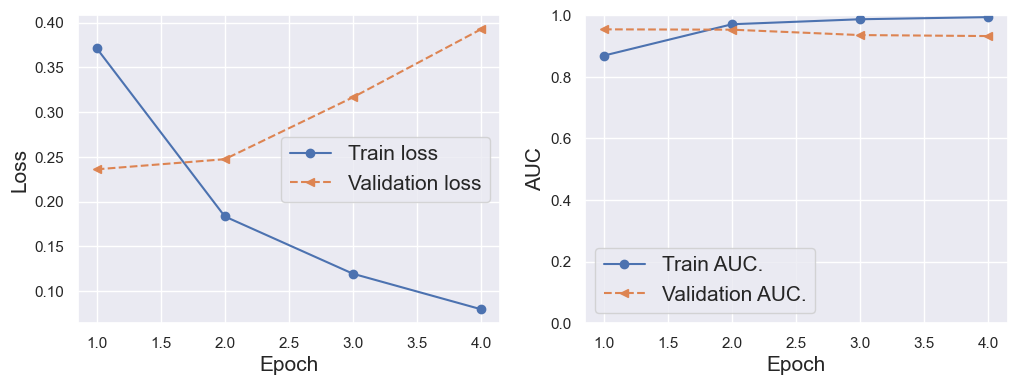

In [31]:
# plot loss curves
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)



# evaluate the AUC of model on (X_train_padded, y_train) and (X_val_padded, y_val)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['auc'], '-o', label='Train AUC.')
ax.plot(x_arr, hist['val_auc'], '--<', label='Validation AUC.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('AUC', size=15)
ax.set_ylim(0,1)
plt.show()

Evaluate our model

In [32]:


# Evaluate the model on test data
test_loss, test_accuracy, test_auc, test_precision, test_recall = best_model.evaluate(X_test_padded, Y_test)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')
print(f'Test AUC: {test_auc}')
print(f'Test Precision: {test_precision}')
print(f'Test Recall: {test_recall}')


129/129 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.8854 - auc: 0.9321 - loss: 0.4072 - precision: 0.9326 - recall: 0.9099
Test Loss: 0.4252476394176483
Test Accuracy: 0.8836017847061157
Test AUC: 0.9310036897659302
Test Precision: 0.9299209713935852
Test Recall: 0.9083892703056335


## Model 6:  Feature Based Transfer Learning using a sentiment classification transformer model


We will load pre trained distilbert-base-uncased-finetuned-sst-2-english transformer model and extract its embedding. We will use the pre trained sentence embeddings (feature extracting) and just train the classifier on top. This model is a fine-tune checkpoint of DistilBERT-base-uncased, fine-tuned on SST-2 sentiment tasks. DistilBert uncased is a light weight version of BERT and trained on lower cased words. 

In [33]:
def tokenize(reviews, labels, tokenizer, seq_length):
    '''tokenize reviews from the data (this will give you: input_ids, attention_mask). '''
    reviews_tokenized = [
        tokenizer(
            n,
            return_tensors='tf',
            truncation=True,
            padding='max_length',
            max_length=seq_length) for n in reviews
    ]

    reviews_tokenized_tensor = tf.convert_to_tensor([
                            (reviews_tokenized[i]['input_ids'],
                              reviews_tokenized[i]['attention_mask'])
                         for i in range(len(reviews_tokenized))
    ])

    # remove empty dimension
    reviews_tokenized_tensor = reviews_tokenized_tensor[:,:,0,:]

    # tensor labels
    labels_tensor = np.array(labels)

    return reviews_tokenized_tensor, labels_tensor

In [34]:
def get_bert_embeddings(bert_auto_model, reviews_tokenized_tensor, feature_size=768):
    ''' extracting sentence embeddings from a BERT model '''
    n = len(reviews_tokenized_tensor)
    seq_len = reviews_tokenized_tensor[0][0].shape[0]
    #bert_pool_embeddings = np.zeros((n, seq_len, feature_size)) # for token embeddings
    bert_pool_embeddings = np.zeros((n, feature_size)) # for sentence embeddings
    bs = 128
    nsteps = n//bs+1

    for i in tqdm.trange(n//bs+1):
        slc = slice(i*bs, (i+1)*bs)
        data = reviews_tokenized_tensor[slc]
        input_ids, attention_mask = data[:,0], data[:,1]
        #embedding = bert_auto_model(input_ids, attention_mask).last_hidden_state # for token embeddings
        embedding = bert_auto_model(input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]
        bert_pool_embeddings[slc] = embedding

    return bert_pool_embeddings

Load the pre-trained distilbert-base-uncased-finetuned-sst-2-english tokenizer and model.

In [35]:
#from transformers import AutoTokenizer, TFAutoModel
hf_model = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(hf_model)
bert_model = TFAutoModel.from_pretrained(hf_model)
bert_model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "tf_distil_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
Total params: 66362880 (253.15 MB)
Trainable params: 66362880 (253.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


We can now apply the tokenizer to our trainining, validation and test datasets. Max token that we will use is 300 which may cut off important sentiment for our longer reviews

In [36]:
train_reviews_tokenized_tensor, train_labels_tensor = tokenize(
    X_train, Y_train, tokenizer, seq_length=300
)

valid_reviews_tokenized_tensor, valid_labels_tensor = tokenize(
    X_val, Y_val, tokenizer, seq_length=300
)

test_reviews_tokenized_tensor, test_labels_tensor = tokenize(
    X_test, Y_test, tokenizer, seq_length=300
)

Create Sentence Embedding from tokenized data
We will use the bert_model imported above to generate text embeddings applied to our own data

In [37]:
print("Doing BERT train embeddings")
train_bert_embeddings = get_bert_embeddings(
    bert_model, train_reviews_tokenized_tensor[:16000,:,:]
) 

print("Doing BERT val embeddings")
valid_bert_embeddings = get_bert_embeddings(
    bert_model, valid_reviews_tokenized_tensor [:4000,:,:]
) 

print("Doing BERT test embeddings")
test_bert_embeddings = get_bert_embeddings(
    bert_model, test_reviews_tokenized_tensor [:12000,:,:]
) 




huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Doing BERT train embeddings


100%|██████████| 97/97 [25:25<00:00, 15.73s/it]


Doing BERT val embeddings


100%|██████████| 32/32 [07:54<00:00, 14.82s/it]


Doing BERT test embeddings


100%|██████████| 33/33 [08:04<00:00, 14.70s/it]


These embeddings are going to be our BERT features that we can next use in a downstream task.

We will use our BERT model on a downstream task of sentiment classification.
To do this, we will create a classifier by adding a `Dense` layer on top of the pretrained BERT features.

In [38]:
# create copy of our objects (a bit inefficient (memory size) but let's abstract away from this)
train_x = train_bert_embeddings
train_y = train_labels_tensor[:16000] 

valid_x = valid_bert_embeddings
valid_y = valid_labels_tensor[:4000]

test_x = test_bert_embeddings
test_y = test_labels_tensor[:12000] 

Define a model for our Downstream task

In [39]:
def build_model(num_features):

    model = tf.keras.Sequential()

    model.add(tf.keras.Input(shape=(num_features,), name='Input'))

    # Output layer
    model.add(tf.keras.layers.Dense(1, activation='sigmoid', name='output'))

    model.summary()

    # print model summary
    model.summary()

    return model

# Build the model
logit_model = build_model(num_features=train_x.shape[1])

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ output (Dense)                  │ (None, 1)              │           769 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 769 (3.00 KB)

 Trainable params: 769 (3.00 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ output (Dense)                  │ (None, 1)              │           769 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 769 (3.00 KB)

 Trainable params: 769 (3.00 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# compile logit model
logit_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)



In [41]:
# train logit model
tf.random.set_seed(1234)
np.random.seed(1234)
hist= logit_model.fit(x=train_x,
                y=train_y,
                #validation_data=[X_test_std, y_test],
                validation_data=(valid_x, valid_y),
                batch_size=32,
                epochs=10,
                verbose=0 #silence fit
)

Print out the loss and AUC curve of our final model on test data


Text(0.5, 1.0, 'AUC')

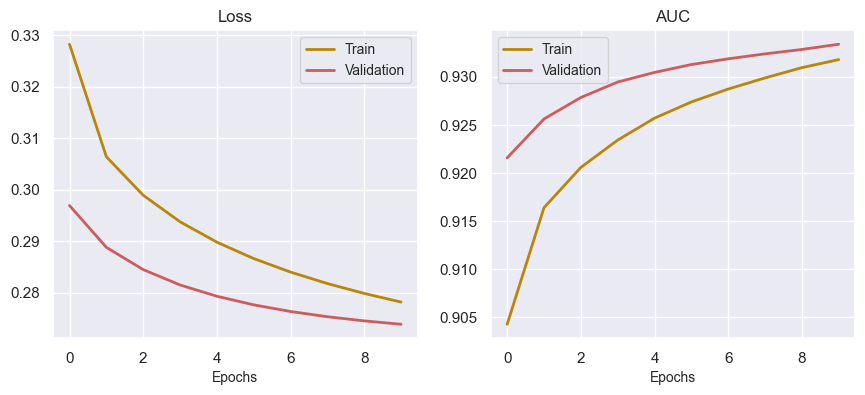

In [42]:
# grab history
history = hist.history

# plot loss for train and validation
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=2, color='darkgoldenrod')
plt.plot(history['val_loss'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
#plt.ylim(0.5,0.7)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Loss');

# Plot AUC for train and validation
ax = fig.add_subplot(1, 3, 2)
plt.plot(history['auc'], lw=2, color='darkgoldenrod')  # Train AUC
plt.plot(history['val_auc'], lw=2, color='indianred')  # Validation AUC
plt.legend(['Train', 'Validation'], fontsize=10)
#plt.ylim(0.7,0.8)  # Optional: Set limits for y-axis
ax.set_xlabel('Epochs', size=10)
ax.set_title('AUC')

Evaluate our logistic model built on frozen bert distill embedding

In [43]:
# run the trained model on the test data (the model outputs probabilities)
test_loss, test_accuracy, test_auc, test_precision, test_recall  = logit_model.evaluate(test_x, test_y)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')
print(f'Test AUC: {test_auc}')
print(f'Test Precision: {test_precision}')
print(f'Test Recall: {test_recall}')




129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - accuracy: 0.8850 - auc: 0.9350 - loss: 0.2739 - precision: 0.9178 - recall: 0.9268 
Test Loss: 0.2720257043838501
Test Accuracy: 0.8843338489532471
Test AUC: 0.9367126822471619
Test Precision: 0.9119000434875488
Test Recall: 0.9308724999427795


## Model 7 Fine-tune a sentiment classification transformer model

In model 7, we seek to fine tune the distilbert-base-uncased-finetuned-sst-2-english even further with our travel data instead of just feature extracting and training the top dense layer like we did for model 6. 

In [44]:
def batch_encode(X, tokenizer, max_seq_len):
    return tokenizer.batch_encode_plus(
    X.tolist(),  # <--- convert here

    max_length=max_seq_len,
    add_special_tokens=True,
    return_attention_mask=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_tensors='tf'
)


In [45]:
def create_model(max_seq_len, model_name, num_labels):
    # Input layers
    input_ids = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32, name='input_ids')
    attention_mask = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32, name='attention_mask')

    # Load BERT
    bert_model = TFAutoModel.from_pretrained(model_name)

    # Lambda wrapper around BERT
    def bert_layer(inputs):
        return bert_model(inputs)[0]  # last_hidden_state

    bert_output = tf.keras.layers.Lambda(
        bert_layer,
        output_shape=(max_seq_len, 768)
    )({'input_ids': input_ids, 'attention_mask': attention_mask})

    # CLS token output
    cls_output = tf.keras.layers.Lambda(lambda x: x[:, 0, :], output_shape=(768,))(bert_output)

    # Dropout (optional)
    cls_output = tf.keras.layers.Dropout(0.3)(cls_output)

    # Dense layer
    output = tf.keras.layers.Dense(num_labels, activation='sigmoid')(cls_output)

    return tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)


In [46]:
max_seq_len = 300
model_name = "distilbert-base-uncased-finetuned-sst-2-english" 

In [47]:
# Load tokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name)


In [48]:
# Prepare our input values (tokenizing, adding special tokens, padding, and attention mask)

train_x = batch_encode(X_train, tokenizer, max_seq_len)
val_x = batch_encode(X_val, tokenizer, max_seq_len)
test_x = batch_encode(X_test, tokenizer, max_seq_len)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/anaconda3/envs/tf_env/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [49]:
# Create and compile model

model = create_model(max_seq_len, model_name, 1)

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), 
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [50]:
train_x = {
    'input_ids': train_x['input_ids'],
    'attention_mask': train_x['attention_mask']
}

val_x = {
    'input_ids': val_x['input_ids'],
    'attention_mask': val_x['attention_mask']
}

test_x = {
    'input_ids': test_x['input_ids'],
    'attention_mask': test_x['attention_mask']
}

hist = model.fit(
    x=train_x,
    y=Y_train,
    validation_data=(val_x, Y_val),
    epochs=10,
    batch_size=32
)

Epoch 1/10
385/385 ━━━━━━━━━━━━━━━━━━━━ 1762s 5s/step - accuracy: 0.7648 - auc: 0.8359 - loss: 0.5211 - precision: 0.8980 - recall: 0.7664 - val_accuracy: 0.8367 - val_auc: 0.8964 - val_loss: 0.4112 - val_precision: 0.9082 - val_recall: 0.8672
Epoch 2/10
385/385 ━━━━━━━━━━━━━━━━━━━━ 1766s 5s/step - accuracy: 0.8276 - auc: 0.8646 - loss: 0.4219 - precision: 0.8910 - recall: 0.8718 - val_accuracy: 0.8536 - val_auc: 0.8986 - val_loss: 0.3672 - val_precision: 0.9027 - val_recall: 0.8991
Epoch 3/10
385/385 ━━━━━━━━━━━━━━━━━━━━ 1831s 5s/step - accuracy: 0.8358 - auc: 0.8702 - loss: 0.3911 - precision: 0.8852 - recall: 0.8921 - val_accuracy: 0.8582 - val_auc: 0.8995 - val_loss: 0.3501 - val_precision: 0.8996 - val_recall: 0.9100
Epoch 4/10
385/385 ━━━━━━━━━━━━━━━━━━━━ 1817s 5s/step - accuracy: 0.8387 - auc: 0.8756 - loss: 0.3753 - precision: 0.8807 - recall: 0.9026 - val_accuracy: 0.8592 - val_auc: 0.9005 - val_loss: 0.3428 - val_precision: 0.8974 - val_recall: 0.9143
Epoch 5/10
385/385 ━━━━━

Text(0.5, 1.0, 'AUC')

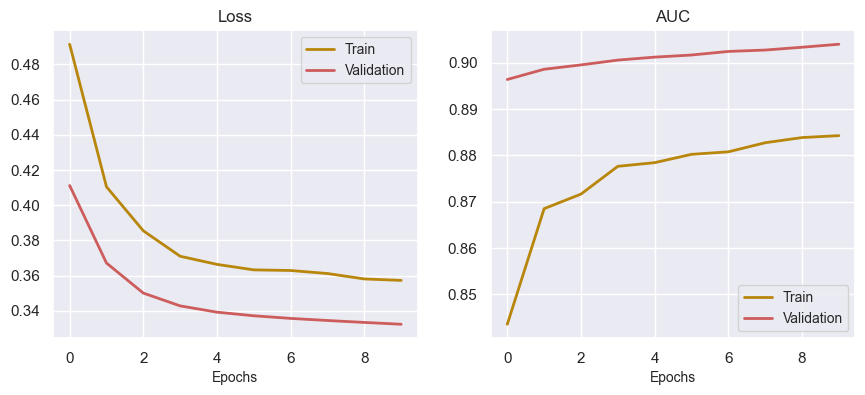

In [51]:
# grab history
history = hist.history

# plot loss for train and validation
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=2, color='darkgoldenrod')
plt.plot(history['val_loss'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
#plt.ylim(0.5,0.7)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Loss');

# Plot AUC for train and validation
ax = fig.add_subplot(1, 3, 2)
plt.plot(history['auc'], lw=2, color='darkgoldenrod')  # Train AUC
plt.plot(history['val_auc'], lw=2, color='indianred')  # Validation AUC
plt.legend(['Train', 'Validation'], fontsize=10)
#plt.ylim(0.7,0.8)  # Optional: Set limits for y-axis
ax.set_xlabel('Epochs', size=10)
ax.set_title('AUC')

In [52]:
# run the trained model on the test data (the model outputs probabilities)
test_loss, test_accuracy, test_auc, test_precision, test_recall  = model.evaluate(test_x, Y_test)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')
print(f'Test AUC: {test_auc}')
print(f'Test Precision: {test_precision}')
print(f'Test Recall: {test_recall}')


129/129 ━━━━━━━━━━━━━━━━━━━━ 423s 3s/step - accuracy: 0.8565 - auc: 0.9018 - loss: 0.3387 - precision: 0.8940 - recall: 0.9134
Test Loss: 0.3354782164096832
Test Accuracy: 0.8599316477775574
Test AUC: 0.906893253326416
Test Precision: 0.892624020576477
Test Recall: 0.9177852272987366


# Section 5: Conlusion / Comparing Models. 

Throughout this project we’ve explored different machine learning models and their ability to predict whether Tripadvisor reviews in our dataset are positive or negative. From our baseline model to our final transformer model we’ve seen how including certain features in algorithms can significantly improve predictive performance for classifying reviews. 

After trying several different models we’ve determined that the most effective one for this use case is the convolutional neural network with hyperparameter tuning. This model employs several useful layers and optimally tuned hyperparameters to generate the highest balance in precision and recall and lowest loss on our test data. It’s proven that it can generalize very well on unseen data and yield a tremendously high AUC. 

Other models that performed noticeably well were the CNN model without hyperparameter tuning and the transformer model without fine tuning. The CNN without fine tuning was very close to the fine tuned CNN in regards to precision, AUC, and recall which suggests that convolutional neural networks perform particularly well for this specific classification task. The transformer model with no fine tuning also had high precision rate and AUC relative to the baseline and other models. We find in our case that further fine tuning the transformer model that was already fine tuned for sentiment tasks brings the performance down. It is probable that our training data set may have introduced more noise and only limiting training token length to 300 and training epoch to 10 descreased the performance of the original transformer model. 

We've also seen that the one-hot encoding model is the least accurate of the ones we've implemented, with a slightly lower precision than our original baseline model. It also had the lowest AUC of any model after the baseline. This is partially due to the fact that we had to decrease the vocabulary size to 1000 compared to the 5000 and 100 review length compared to 1000 for the neural models and 300 for transformer based models. This was due to limited memory space as one hot encoding models are memory intensive. 

One area of future research could be to create a model that can employ multiclass classification to predict the exact star rating of different hotels based on a large sample of review data. This could help further improve the reliability of ratings on Tripadvisor and help travelers better understand the hotels that they choose to book. For now the results from this project could be used to help Tripadvisor users gain basic insights into whether or not they should consider staying in different hotels.

| Model                                        | Test Precision | Test Recall | Test AUC |
|----------------------------------------------|----------------|-------------|-----------|
| Baseline                                     | 0.7385         | 1.0         |0.5
| One Hot Encoding                             | 0.73           | 1.0         |0.783
| Logistic Regression w/Embedding              | 0.922          | 1.0         |0.926
| CNN w/Embedding                              | 0.899          | 0.955       |0.923
| CNN w/Embedding & hyperparameter tuning      | 0.93           | 0.91        |0.931
| Transformer Model Embedding only             | 0.912          | 0.931       |0.937
| Transformer Model Fine Tuned                 | 0.893          | 0.918       |0.907

